# Trade Flows playground

Clean up the stuff below. Join/agg etc.

Plot a scatter, time whatever.

In [1]:
%matplotlib inline
from pylab import *
import os
import mylib.spark as ms
import pyspark.sql.functions as F

In [2]:
sc, spark = ms.get_spark_context_and_session()
# df = spark.read.parquet(
#     os.path.expanduser('~/projects/data/extractors/oec/bulk_file/filename=year_origin_destination_hs07_4'))
df = spark.read.parquet(
    os.path.expanduser('~/projects/data/extractors/oec/bulk_file/filename=year_origin_destination_sitc_rev2'))

product = spark.read.parquet(os.path.expanduser('~/projects/data/extractors/oec/bulk_file/filename=products_hs_07'
))
country = spark.read.parquet(os.path.expanduser('~/projects/data/extractors/oec/bulk_file/filename=country_names'))

In [3]:
df.count() / 1e6

117.815031

# Extra cur/country data

Want map country to currency, need alpha 2 alpha 3 codes.

Need to drop dupes from these sources.

In [4]:
![ -e b61a5bdf5f3d5c69399f9d9e592c4896fd0dc53c.zip ] || wget https://gist.github.com/HarishChaudhari/4680482/archive/b61a5bdf5f3d5c69399f9d9e592c4896fd0dc53c.zip
!unzip -o b61a5bdf5f3d5c69399f9d9e592c4896fd0dc53c.zip
cur = pd.read_csv('4680482-b61a5bdf5f3d5c69399f9d9e592c4896fd0dc53c/country-code-to-currency-code-mapping.csv')
cur.head()

Archive:  b61a5bdf5f3d5c69399f9d9e592c4896fd0dc53c.zip
b61a5bdf5f3d5c69399f9d9e592c4896fd0dc53c
  inflating: 4680482-b61a5bdf5f3d5c69399f9d9e592c4896fd0dc53c/country-code-to-currency-code-mapping.csv  


,Country,CountryCode,Currency,Code
0,New Zealand,NZ,New Zealand Dollars,NZD
1,Cook Islands,CK,New Zealand Dollars,NZD
2,Niue,NU,New Zealand Dollars,NZD
3,Pitcairn,PN,New Zealand Dollars,NZD
4,Tokelau,TK,New Zealand Dollars,NZD


In [5]:
#dupes
cur.CountryCode.value_counts().sort_values().tail()
cur[cur.CountryCode == 'LA']

,Country,CountryCode,Currency,Code
156,Lao PeopleÕs Democratic Republic,LA,Kip,LAK
240,Laos,LA,Lao kip,LAK


In [6]:
cur = cur.drop_duplicates('CountryCode')

In [7]:
![ -e 7255fdfbf292c592b75cf5f7a19c16ea59735f74.zip ] || wget https://gist.github.com/tadast/8827699/archive/7255fdfbf292c592b75cf5f7a19c16ea59735f74.zip
!unzip -o 7255fdfbf292c592b75cf5f7a19c16ea59735f74.zip
c2 = pd.read_csv('8827699-7255fdfbf292c592b75cf5f7a19c16ea59735f74/countries_codes_and_coordinates.csv')
c2 = c2.applymap(lambda x: x.replace('"', '').strip())
c2.head()

Archive:  7255fdfbf292c592b75cf5f7a19c16ea59735f74.zip
7255fdfbf292c592b75cf5f7a19c16ea59735f74
  inflating: 8827699-7255fdfbf292c592b75cf5f7a19c16ea59735f74/countries_codes_and_coordinates.csv  


,Country,Alpha-2 code,Alpha-3 code,Numeric code,Latitude (average),Longitude (average)
0,Afghanistan,AF,AFG,4,33,65
1,Albania,AL,ALB,8,41,20
2,Algeria,DZ,DZA,12,28,3
3,American Samoa,AS,ASM,16,-14.3333,-170
4,Andorra,AD,AND,20,42.5,1.6


In [8]:
#dupes
c2[c2['Alpha-3 code'] == 'VCT']

,Country,Alpha-2 code,Alpha-3 code,Numeric code,Latitude (average),Longitude (average)
193,Saint Vincent and the Grenadines,VC,VCT,670,13.25,-61.2
194,Saint Vincent & the Grenadines,VC,VCT,670,13.25,-61.2
195,St. Vincent and the Grenadines,VC,VCT,670,13.25,-61.2


In [9]:
c2['Alpha-3 code'] = c2['Alpha-3 code'].str.lower()

In [10]:
c2 = c2.drop_duplicates('Alpha-3 code')
assert c2['Alpha-2 code'].value_counts().max() == 1 # check this is true
before = c2.shape[0]
post = c2.join(cur.set_index('CountryCode')[['Currency', 'Code']], on=['Alpha-2 code'])
assert before == post.shape[0]
c2 = post

c2.head()

,Country,Alpha-2 code,Alpha-3 code,Numeric code,Latitude (average),Longitude (average),Currency,Code
0,Afghanistan,AF,afg,4,33,65,Afghani,AFN
1,Albania,AL,alb,8,41,20,Lek,ALL
2,Algeria,DZ,dza,12,28,3,Algerian Dinar,DZD
3,American Samoa,AS,asm,16,-14.3333,-170,Euros,EUR
4,Andorra,AD,and,20,42.5,1.6,Euros,EUR


In [11]:
#maybe don'e need this
import pyspark
def create_spark_dataframe(df):
    sqlContext = pyspark.sql.SQLContext(sc)
    for col in df.columns:
      if ((df[col].dtypes != np.int64) & (df[col].dtypes != np.float64)):
        df[col] = df[col].fillna('')

    spark_data_frame = sqlContext.createDataFrame(df)
    return spark_data_frame

cc = create_spark_dataframe(c2)

## The main aggs and maps

In [12]:
s = df.groupby(['year', 'dest', 'origin']).agg(F.sum('export_val').alias('export'), F.sum('import_val').alias('import')).dropna(how='all')
country = country.withColumn('continent', F.substring('id', 0, 2))
assert country.groupby('id_3char').count().select(F.max('count')).collect()[0][0] == 1
s = s.join(
    country.drop('origin').withColumnRenamed('id_3char', 'origin')[['origin', 'continent']],
    on='origin',
    how='left').withColumnRenamed('continent', 'origin_continent')
s = s.join(
    country.drop('origin').withColumnRenamed('id_3char', 'dest')[['dest', 'continent']],
    on='dest',
    how='left').withColumnRenamed('continent', 'dest_continent')
assert product.groupby('hs07').count().select(F.max('count')).collect()[0][0] == 1
# don't need product right now

# s = s[(s.origin_continent == 'eu') & (s.dest_continent == 'eu')]
d = s.toPandas() # .drop(['origin_continent', 'dest_continent'], axis=1)

## Join the orig/dest currencies

Agg on these, as coarses than country

In [13]:
before = d.shape[0]
post = d.join(
    c2.set_index('Alpha-3 code').rename(columns={'Currency': 'cur', 'Code': 'orig_cur'})['orig_cur'],
    on=['origin'], how='left')
assert post.shape[0] == before
d = post

before = d.shape[0]
post = d.join(
    c2.set_index('Alpha-3 code').rename(columns={'Currency': 'cur', 'Code': 'dest_cur'})['dest_cur'],
    on=['dest'], how='left')
assert post.shape[0] == before
d = post

In [14]:
# restrict to main continents
_continents = ['af', 'eu', 'as', 'na', 'oc', 'sa']
print(d.shape)
d = d[d.origin_continent.isin(_continents) & d.dest_continent.isin(_continents)].copy()
print(d.shape)

(1000816, 9)
(977749, 9)


In [52]:
# more enrichment
d['orig_eu'] = np.where(d.origin_continent == 'eu', 'eu', 'ex-eu')
d['dest_eu'] = np.where(d.dest_continent == 'eu', 'eu', 'ex-eu')
d['dest_cur_eu'] = np.where(d.dest_cur == 'EUR', 'EUR', 'ex-EUR')


d['orig_uk'] = np.where(d.origin == 'gbr', 'gbr', 'eu-ex-gbr')

In [53]:
d.head()

,dest,origin,year,export,import,origin_continent,dest_continent,orig_cur,dest_cur,orig_eu,dest_eu,orig_uk,dest_cur_eu
0,caf,usa,2008,2.302231e+07,8.149550e+06,na,af,USD,XAF,ex-eu,ex-eu,eu-ex-gbr,ex-EUR
1,cod,usa,2008,1.254868e+08,2.427750e+08,na,af,USD,CDF,ex-eu,ex-eu,eu-ex-gbr,ex-EUR
2,dji,usa,2008,1.374346e+08,6.342346e+06,na,af,USD,DJF,ex-eu,ex-eu,eu-ex-gbr,ex-EUR
3,egy,usa,2008,5.853884e+09,2.218758e+09,na,af,USD,EGP,ex-eu,ex-eu,eu-ex-gbr,ex-EUR
4,eth,usa,2008,2.980332e+08,1.432613e+08,na,af,USD,ETB,ex-eu,ex-eu,eu-ex-gbr,ex-EUR


# Now look at flows by currency and dest_cur_eu

TODO: net flows EUR -> EUR should be zero. From 2011 onward something is wrong in the data!

In [55]:
dd = d.copy()

dd = dd[dd.origin_continent == 'eu'].copy()

i = dd.groupby(['year', 'orig_cur']).sum()[['export', 'import']].groupby(level=['orig_cur']).mean().sum(axis=1)
small = i[i<3e10].index
dd['orig_cur'] = np.where(dd['orig_cur'].isin(small), ' {}_smallest_eu'.format(len(small)), dd['orig_cur'].values)

dd = dd.groupby(['year', 'orig_cur', 'dest_cur_eu']).sum() / 1e9
dd['net'] = dd['export'] - dd['import']
dd = dd.unstack(['year', 'dest_cur_eu'])
dd.columns = dd.columns.reorder_levels([1, 2, 0])
dd = dd.sort_values((2014, 'EUR', 'net')).sort_index(axis=1).fillna(0)
print(dd.shape)
dd.head()

(13, 318)


year                 1962                                                         1963                                                         1964                                                         1965                                                          1966                      \
dest_cur_eu           EUR                        ex-EUR                            EUR                        ex-EUR                            EUR                        ex-EUR                            EUR                         ex-EUR                            EUR                       
                   export    import       net    export     import       net    export    import       net    export     import       net    export    import       net    export     import       net    export    import       net     export     import       net    export    import       net   
orig_cur                                                                                                                                                                                                                                                                                             
GBP              2.988239  2.956223  0.032016  8.406607  10.182013 -1.775406  3.469842  3.218368  0.251474  8.987501  10.881651 -1.894150  3.746431  3.785422 -0.038991  9.655257  12.485009 -2.829752  3.937663  4.047015 -0.109352  10.563231  12.928933 -2.365702  4.268453  4.457190 -0.188737   
 15_smallest_eu  0.227428  0.265004 -0.037576  0.267915   0.380274 -0.112359  0.320985  0.320011  0.000974  0.302216   0.433482 -0.131266  0.312504  0.405808 -0.093304  0.357569   0.540850 -0.183281  0.384020  0.488350 -0.104330   0.450209   0.625517 -0.175308  0.453896  0.637186 -0.183290   
SEK              1.303964  1.415376 -0.111412  2.301610   2.402700 -0.101090  1.394080  1.470521 -0.076441  2.399206   2.665833 -0.266627  1.604258  1.634117 -0.029859  2.833839   3.071201 -0.237362  1.734174  1.875215 -0.141041   3.098892   3.472078 -0.373186  1.843535  1.927772 -0.084237   
CHF              1.091241  2.030453 -0.939212  1.491002   1.918520 -0.427518  1.204435  2.210210 -1.005775  1.612240   2.049980 -0.437740  1.292979  2.396689 -1.103710  1.770546   2.285104 -0.514558  1.432850  2.459999 -1.027149   2.035887   2.321337 -0.285450  1.576807  2.564099 -0.987292   
DKK              0.554545  0.903848 -0.349303  1.388822   1.694156 -0.305334  0.627250  0.866910 -0.239660  1.535913   1.716701 -0.180788  0.673553  1.061373 -0.387820  1.731925   2.103390 -0.371465  0.757794  1.153041 -0.395247   1.894780   2.281748 -0.386968  0.749623  1.197229 -0.447606   

year                                                 1967                                                          1968                                                          1969                                                          1970              ...            2006              \
dest_cur_eu         ex-EUR                            EUR                         ex-EUR                            EUR                         ex-EUR                            EUR                         ex-EUR                            EUR              ...          ex-EUR               
                    export     import       net    export    import       net     export     import       net    export    import       net     export     import       net    export    import       net     export     import       net    export    import    ...          import         net   
orig_cur                                                                                                                                                                                                                                                         ...                               
GBP              11.185709  13.086096 -1.900387  4.126965  5.044236 -0.917271  11.069021  13.631167 -2.562146  4.481624  5.461018 -0.979394  11.905392  14.581403 -2.676011  5.398011  5.

In [59]:
n = min(10, len(dd.columns.levels[0])) # year
n

10

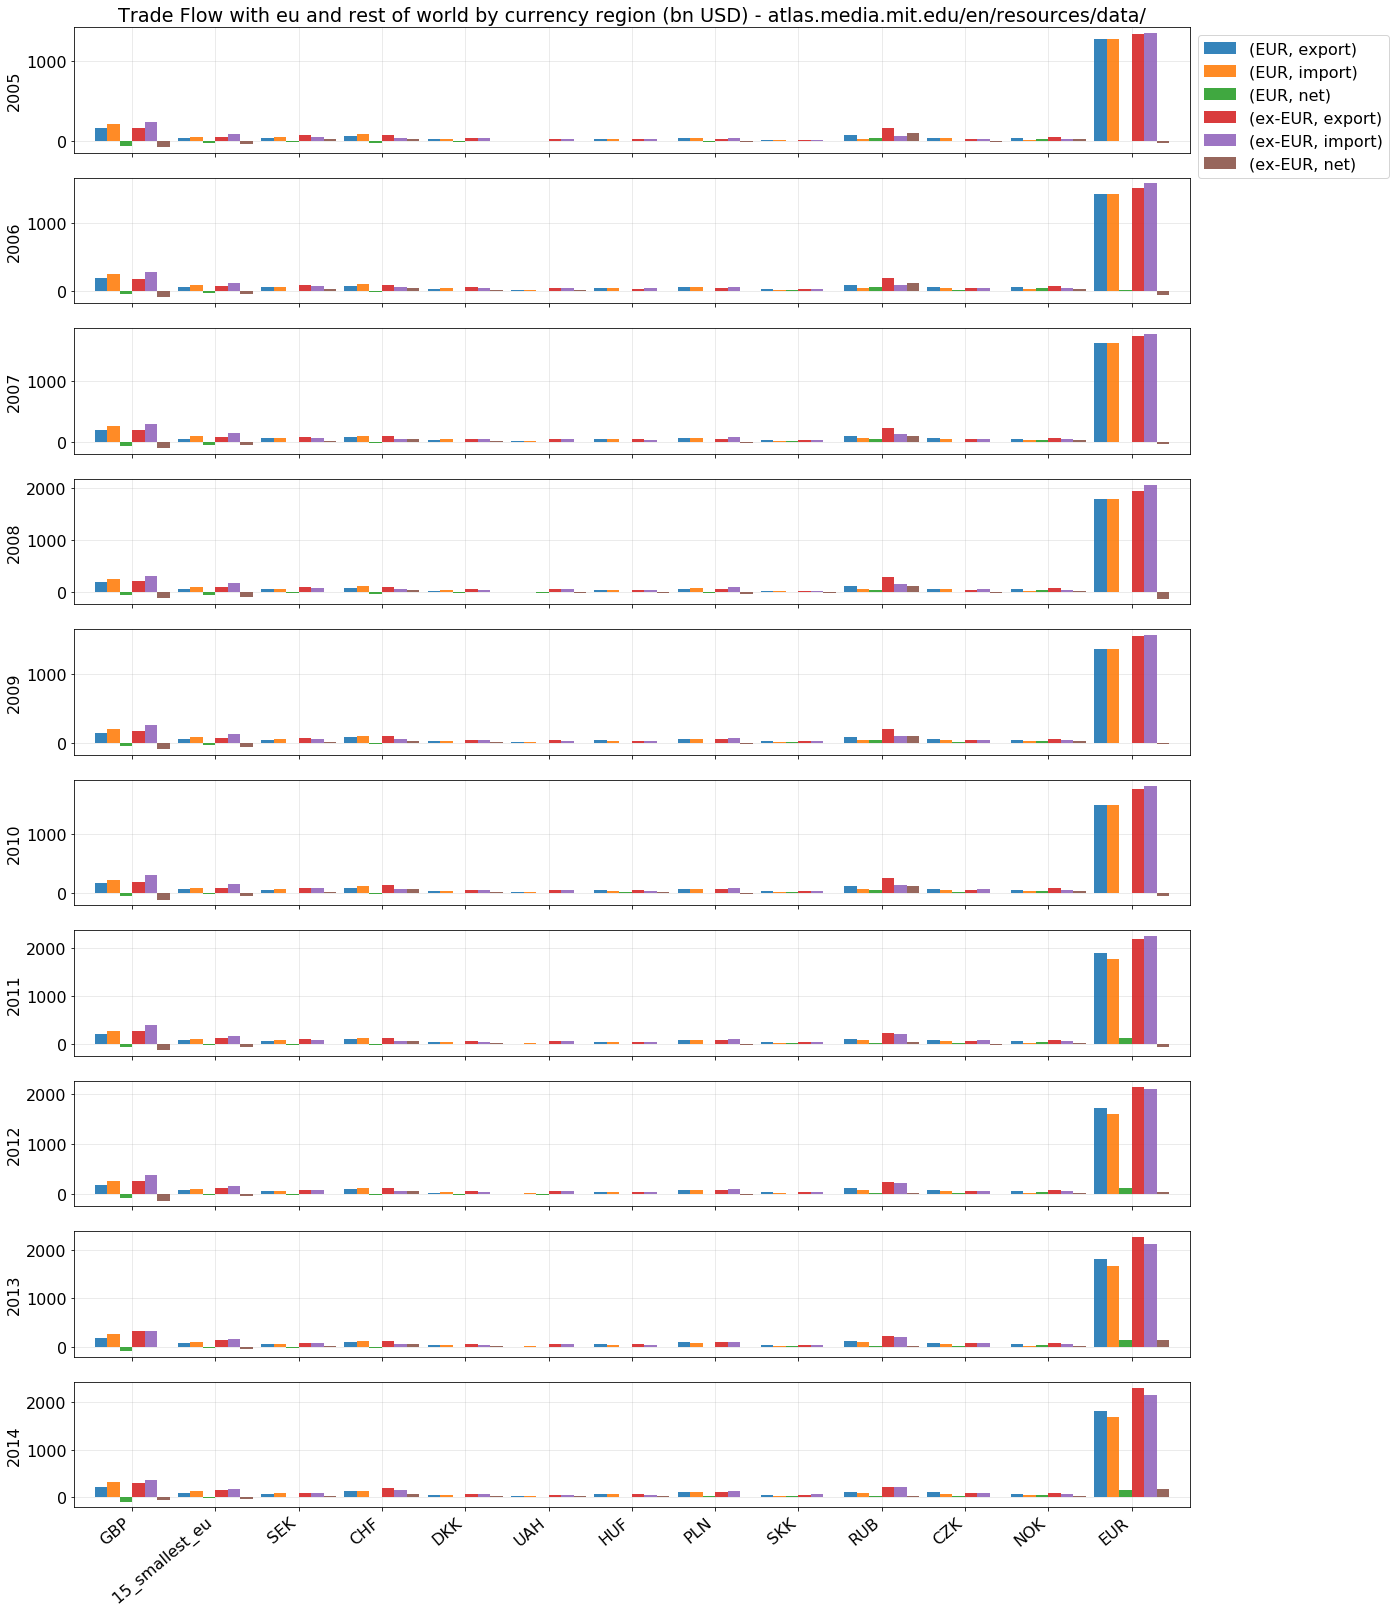

In [60]:
fig = figure(figsize=(20, 3 * n))

matplotlib.rcParams.update({'font.size': 16})
for i, k in enumerate(ddd.columns.levels[0][-n:]):
    v = dd[k]
    legend_ = False
    subplot(n+1, 1, i+1)

    v.plot(kind='bar', ax=gca(), alpha=0.9, width=0.9, rot=40, legend=legend_, zorder=3)
    if i == 0:
        legend_ = True
        legend(loc="upper left", bbox_to_anchor=(1,1))
        title('Trade Flow with eu and rest of world by currency region (bn USD) - atlas.media.mit.edu/en/resources/data/')
    ylabel(k)
    grid(zorder=0, alpha=0.3)
    if i != (n-1):
        gca().set_xticklabels([])
    else:
        gca().set_xticklabels(gca().get_xticklabels(), ha='right')
    gca().set_xlabel('')
# savefig('trade_flow.png')

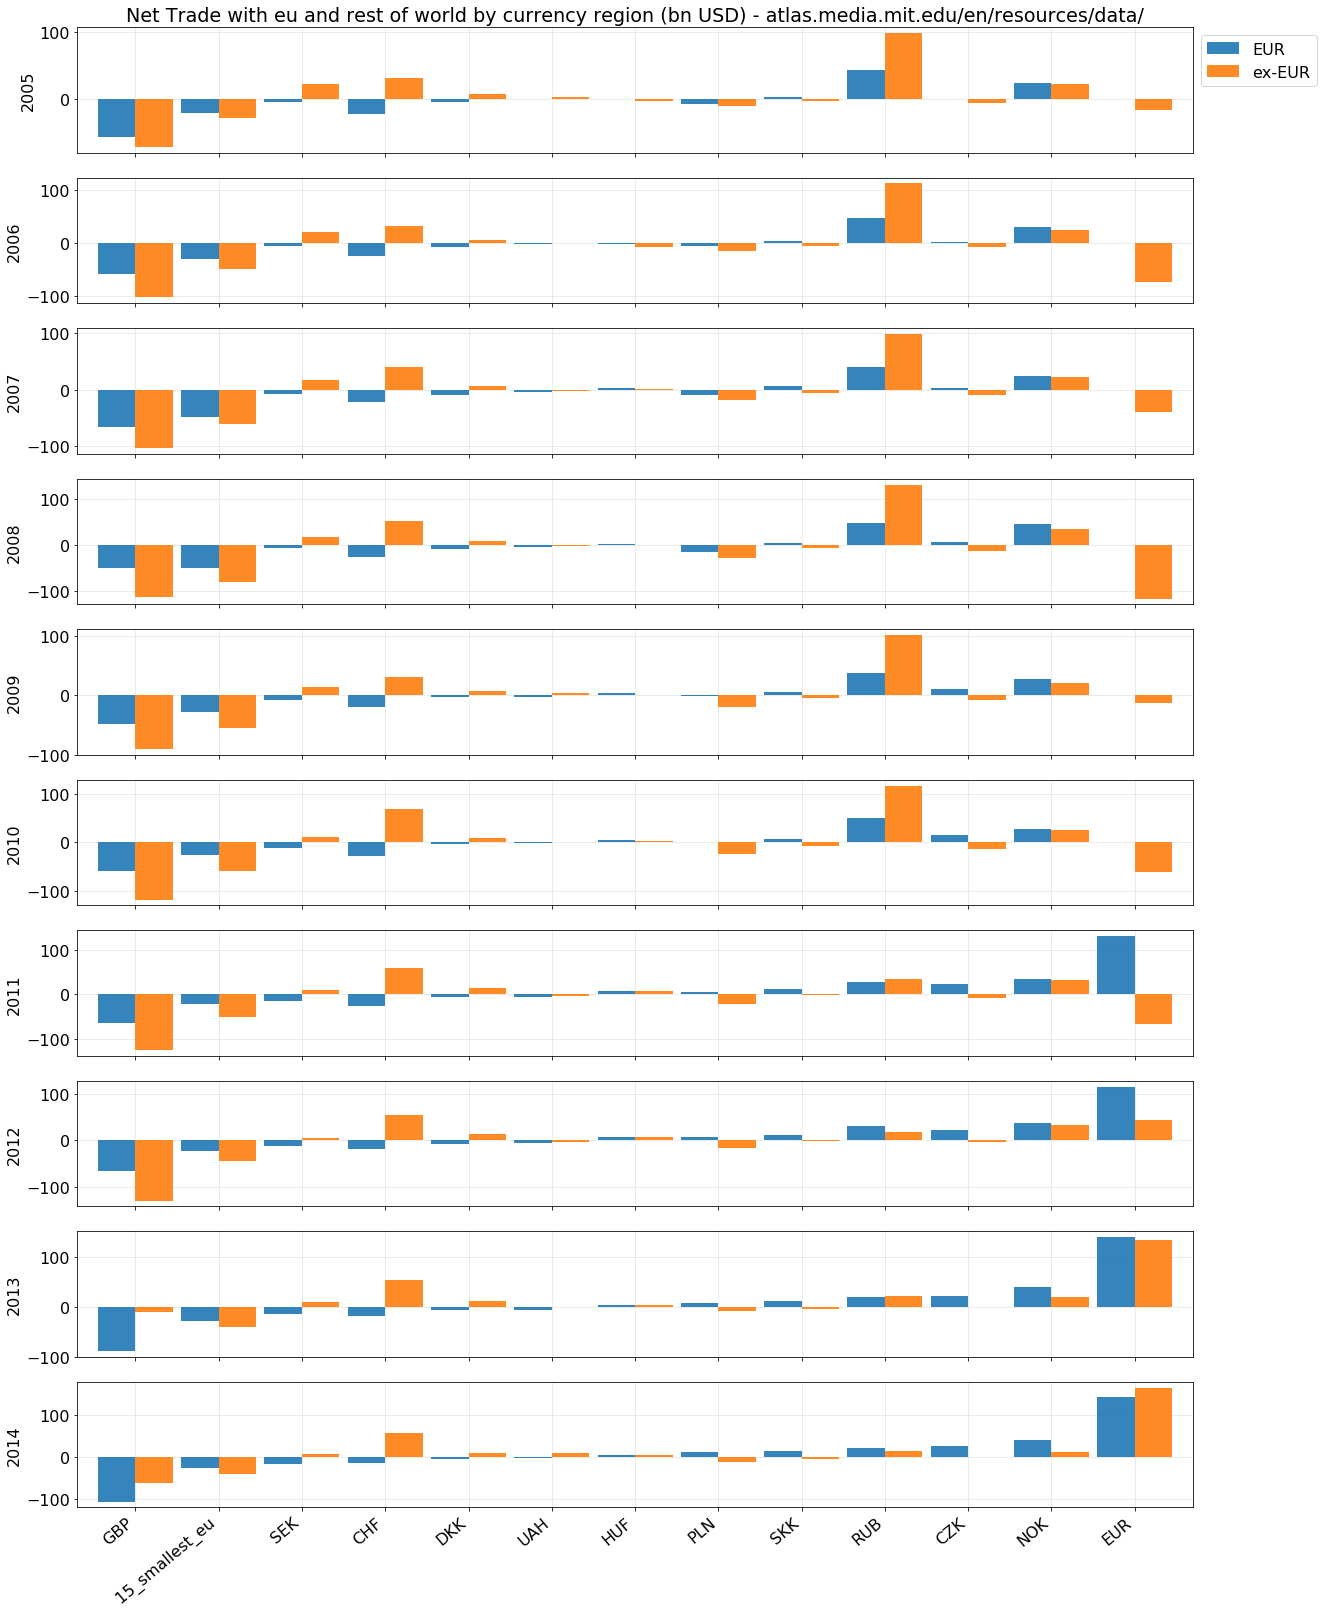

In [61]:
fig = figure(figsize=(20, 3 * n))

matplotlib.rcParams.update({'font.size': 16})
for i, k in enumerate(ddd.columns.levels[0][-n:]):
    v = dd[k].xs('net', axis=1, level=1)
    legend_ = False
    subplot(n+1, 1, i+1)

    v.plot(kind='bar', ax=gca(), alpha=0.9, width=0.9, rot=40, legend=legend_, zorder=3)
    if i == 0:
        legend_ = True
        legend(loc="upper left", bbox_to_anchor=(1,1))
        title('Net Trade with eu and rest of world by currency region (bn USD) - atlas.media.mit.edu/en/resources/data/')
    ylabel(k)
    grid(zorder=0, alpha=0.3)
    if i != (n-1):
        gca().set_xticklabels([])
    else:
        gca().set_xticklabels(gca().get_xticklabels(), ha='right')
    gca().set_xlabel('')

# What do total flows look like?

Non-zero net flows are errors? 

In [ ]:
figure(figsize=(12, 8))
d['net'] = d['export'] - d['import']
d['total'] = (d['export'] + d['import']) / 2
d.groupby('year')[['export', 'import', 'net']].sum().plot(ax=gca())

# Region flows?

In [311]:
s = d.groupby(['year', 'origin_continent', 'dest_continent'])[['export', 'import']].sum()


# .unstack().unstack()
# s.columns = s.columns.reorder_levels([2, 1, 0])
s.head()

export        import
year origin_continent dest_continent                            
1962 eu               af              5.039495e+09  5.710741e+09
                      as              6.620606e+09  8.281713e+09
                      eu              5.671515e+10  5.671515e+10
                      na              7.554097e+09  1.156691e+10
                      oc              1.597000e+09  2.009833e+09

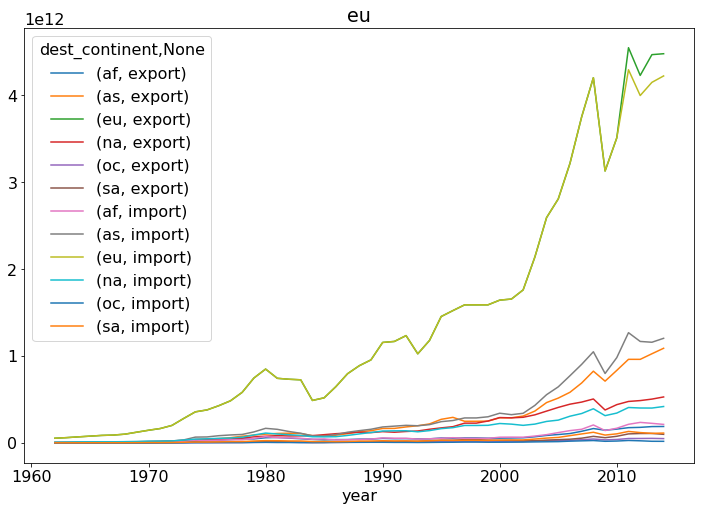

In [307]:
for k in s.columns.levels[0]:
    v = s[k]
    figure(figsize=(12, 8))
    v.plot(ax=gca())
    title(k)

In [252]:
d.head()

,dest,origin,year,export,import,origin_continent,dest_continent,orig_eu,dest_eu,orig_uk
566,ago,deu,2013,345297766.0,541967600.0,eu,af,eu,ex-eu,eu-ex-gbr
567,bdi,deu,2013,20906892.0,10343718.0,eu,af,eu,ex-eu,eu-ex-gbr
568,ben,deu,2013,122773529.0,10548333.0,eu,af,eu,ex-eu,eu-ex-gbr
569,bfa,deu,2013,63000848.0,14297956.0,eu,af,eu,ex-eu,eu-ex-gbr
570,bwa,deu,2013,43802842.0,6621721.0,eu,af,eu,ex-eu,eu-ex-gbr


In [253]:
c = country.toPandas()
c[c.id_3char == 'blx']

,id,id_3char,name,ingress_time,origin,continent
127,eublx,blx,Belgium-Luxembourg,2019-01-18 20:42:43.957504,None,eu


# yearly flows are pretty stable

Just use the mean

In [422]:
d = d[d.origin_continent == 'eu'].copy()

In [423]:
dd = d.groupby(['year', 'origin_cur'])[['export', 'import']].sum() / 1e9
dd = dd.unstack('origin')

figure(figsize=(20, 8))
dd.plot(ax=gca(), alpha=0.5, legend=False)

KeyError: 'origin_cur'

In [269]:
dd = d.copy()

i = dd.groupby(['year', 'origin']).sum().loc[2014].groupby(level=['origin']).mean().sum(axis=1)
small = i[i<100e9].index
print(small)
dd['origin'] = np.where(dd.origin.isin(small), ' {}_smallest_eu'.format(len(small)), dd.origin.values)

dd = dd.groupby(['year', 'origin', 'dest_eu']).sum() / 1e9
dd['net'] = dd['export'] - dd['import']
dd = dd.unstack(['year', 'dest_eu'])
dd.columns = dd.columns.reorder_levels([1, 2, 0])
dd = dd.sort_values((2014, 'eu', 'net')).sort_index(axis=1)

Index(['alb', 'and', 'bgr', 'bih', 'blr', 'est', 'grc', 'hrv', 'isl', 'ltu', 'lux', 'lva', 'mda', 'mkd', 'mlt', 'mne', 'srb', 'svn'], dtype='object', name='origin')


In [270]:
n = len(dd.columns.levels[0])
n

53

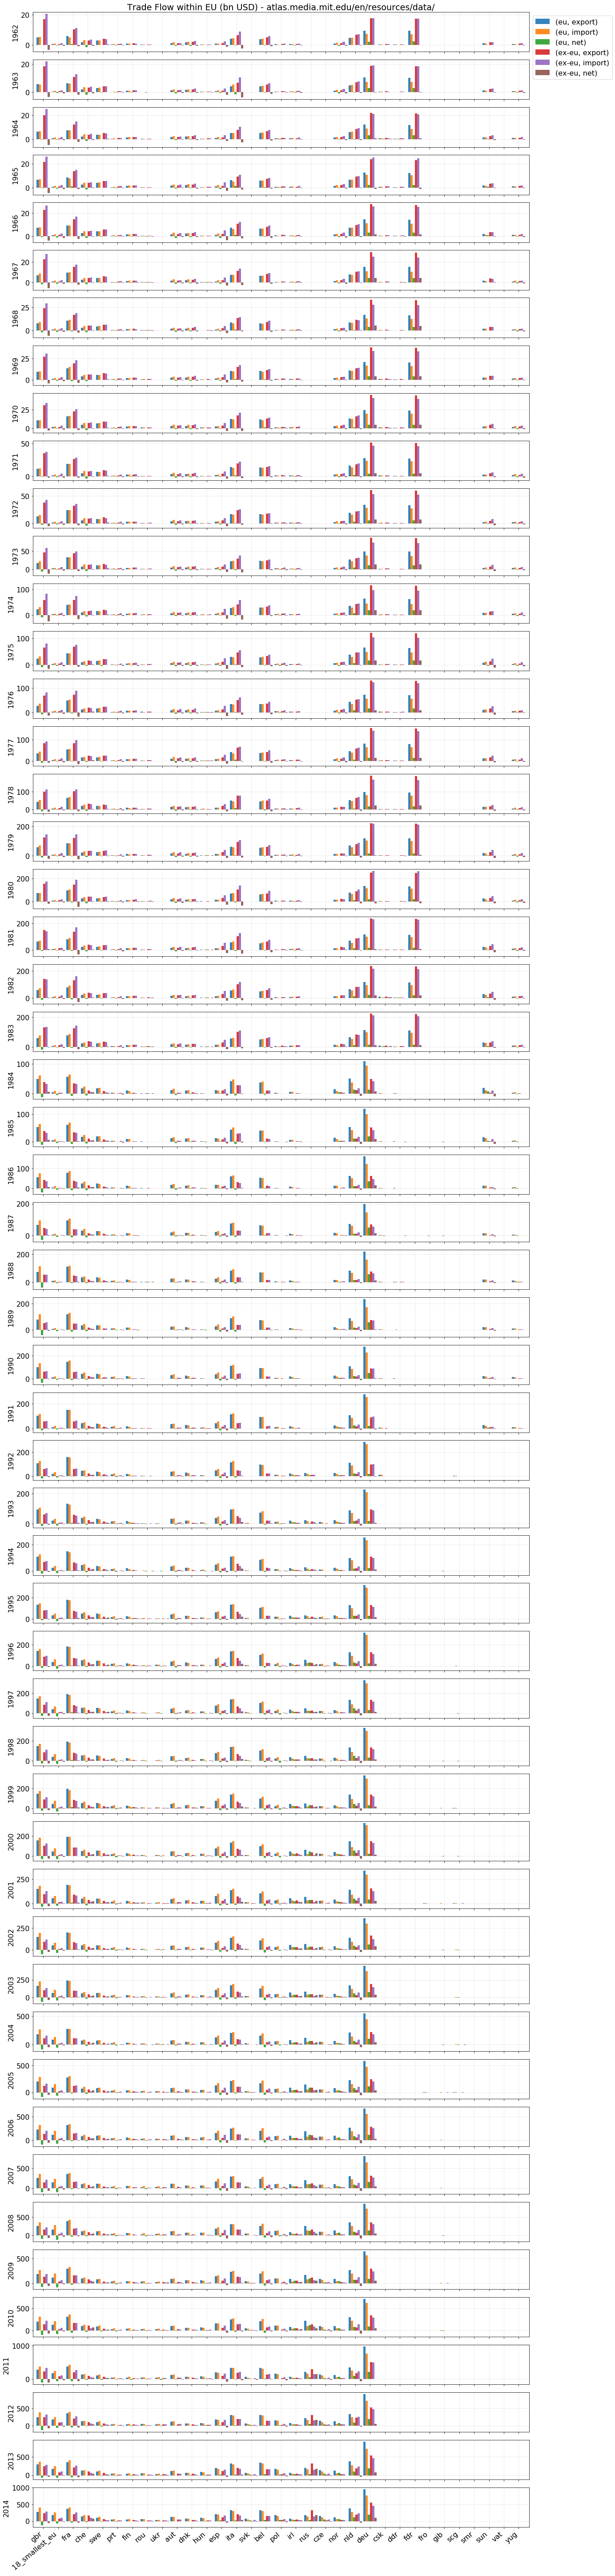

In [271]:
fig = figure(figsize=(20, 2 * n))

matplotlib.rcParams.update({'font.size': 16})
for i, k in enumerate(dd.columns.levels[0]):
    v = dd[k]
    legend_ = False
    subplot(n+1, 1, i+1)

    v.plot(kind='bar', ax=gca(), alpha=0.9, width=0.9, rot=40, legend=legend_, zorder=3)
    if i == 0:
        legend_ = True
        legend(loc="upper left", bbox_to_anchor=(1,1))
        title('Trade Flow within EU (bn USD) - atlas.media.mit.edu/en/resources/data/')
    ylabel(k)
    grid(zorder=0, alpha=0.3)
    if i != (n-1):
        gca().set_xticklabels([])
    else:
        gca().set_xticklabels(gca().get_xticklabels(), ha='right')
    gca().set_xlabel('')
savefig('trade_flow.png')

# Who has become sellers to outside of EU?

In [220]:
dd = d.copy()

dd = dd.groupby(['year', 'orig_uk', 'dest_eu']).sum() / 1e9
dd['net'] = dd['export'] - dd['import']
dd = dd.unstack(['year', 'dest_eu'])
dd.columns = dd.columns.reorder_levels([1, 2, 0])
dd = dd.sort_values((2014, 'eu', 'net')).sort_index(axis=1)

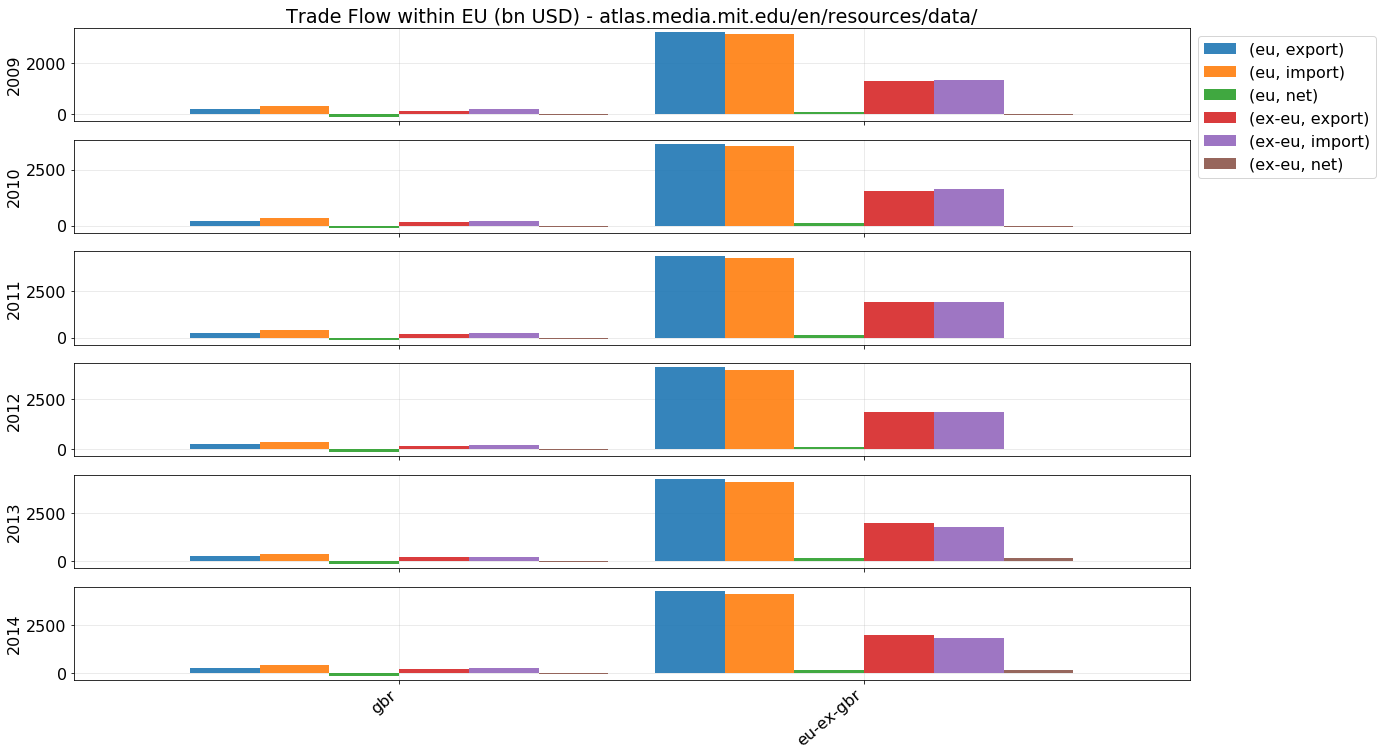

In [222]:
fig = figure(figsize=(20, 12))

matplotlib.rcParams.update({'font.size': 16})
for i, k in enumerate(dd.columns.levels[0]):
    v = dd[k]
    if i == 0:
        continue
    legend_ = False
    subplot(6, 1, i)

    v.plot(kind='bar', ax=gca(), alpha=0.9, width=0.9, rot=40, legend=legend_, zorder=3)
    if i == 1:
        legend_ = True
        legend(loc="upper left", bbox_to_anchor=(1,1))
        title('Trade Flow within EU (bn USD) - atlas.media.mit.edu/en/resources/data/')
    ylabel(k)
    grid(zorder=0, alpha=0.3)
    if i != 6:
        gca().set_xticklabels([])
    else:
        gca().set_xticklabels(gca().get_xticklabels(), ha='right')
    gca().set_xlabel('')

In [226]:
dd.stack().stack()

year                             2008         2009         2010         2011         2012         2013         2014
orig_uk          dest_eu                                                                                           
gbr       export eu        280.082648   203.210169   225.761369   267.532740   247.074842   252.421282   274.929460
                 ex-eu     173.237355   139.298705   162.117054   182.551044   190.506164   201.473472   199.987237
          import eu        414.584910   303.413270   347.125658   401.200443   380.577235   397.834609   419.572250
                 ex-eu     239.979884   186.940513   219.723356   250.181720   234.979793   232.692398   248.328585
          net    eu       -134.502262  -100.203101  -121.364289  -133.667703  -133.502393  -145.413327  -144.642790
                 ex-eu     -66.742529   -47.641808   -57.606302   -67.630676   -44.473630   -31.218926   -48.341348
eu-ex-gbr export eu       4359.166503  3245.033991  3665.586402  4402.653179  4082.124213  4276.155592  4285.530850
                 ex-eu    1652.570890  1305.790340  1556.376032  1895.701705  1864.518340  1976.272058  1969.391047
          import eu       4224.664241  3144.830890  3544.222113  4268.985476  3948.621820  4130.742265  4140.888059
                 ex-eu    1818.666384  1345.330627  1629.007615  1919.230039  1849.814608  1806.802073  1815.815168
          net    eu        134.502262   100.203101   121.364289   133.667703   133.502393   145.413327   144.642790
                 ex-eu    -166.095495   -39.540288   -72.631583   -23.528334    14.703731   169.469985   153.575879

In [243]:
dd = d.groupby(['year', 'origin', 'dest_eu'])[['import', 'export']].sum()
dd['net'] = dd['export'] - dd['import']
dd = dd.unstack().unstack()
dd

import                                                                                                                                                                                                                                                                            \
dest_eu            eu                                                                                                                                                                                                                                                                             
origin            alb           and           aut           bgr           bih           blr           blx           che           cze           deu           dnk           esp           est           fin           fra           gbr           gib           grc           hrv           hun   
year                                                                                                                                                                                                                                                                                              
2008     3.082234e+09  1.838085e+09  1.412345e+11  2.701073e+10  1.001219e+10  3.380542e+10  3.392352e+11  1.482626e+11  1.075965e+11  7.170086e+11  8.726263e+10  2.491320e+11  1.327799e+10  6.890998e+10  4.791479e+11  4.145849e+11  5.054974e+09  5.902398e+10  2.476206e+10  8.114052e+10   
2009     3.305244e+09  1.494171e+09  1.114289e+11  1.722147e+10  7.099687e+09  2.392812e+10  2.600387e+11  1.267050e+11  7.810055e+10  5.549898e+11  6.316975e+10  1.810449e+11  8.930091e+09  4.390290e+10  3.777719e+11  3.034133e+11  4.939304e+09  4.429206e+10  1.633950e+10  5.450672e+10   
2010     3.394052e+09  1.440910e+09  1.228145e+11  2.077528e+10  7.538081e+09  2.750398e+10  2.792533e+11  1.451003e+11  9.098760e+10  6.382954e+11  6.373379e+10  1.895735e+11  1.112261e+10  5.202126e+10  4.104285e+11  3.471257e+11  6.792951e+09  3.996678e+10  1.542598e+10  6.233838e+10   
2011     3.954114e+09  1.533505e+09  1.477138e+11  2.601726e+10  9.022764e+09  3.516269e+10  3.281659e+11  1.730654e+11  1.122931e+11  7.794620e+11  7.644378e+10  2.082718e+11  1.590633e+10  6.599939e+10  4.811149e+11  4.012004e+11  1.156235e+10  3.925970e+10  1.730293e+10  7.651973e+10   
2012     3.545741e+09  1.330648e+09  1.348641e+11  2.668212e+10  8.313539e+09  3.744184e+10  3.076025e+11  1.614002e+11  1.046314e+11  7.201761e+11  7.354784e+10  1.787983e+11  1.724016e+10  5.403730e+10  4.340839e+11  3.805772e+11  1.266998e+10  3.642884e+10  1.568595e+10  6.985186e+10   
2013     3.703395e+09  1.355158e+09  1.397473e+11  2.781310e+10  8.533807e+09  3.434169e+10  3.434682e+11  1.678622e+11  1.091332e+11  7.727983e+11  7.642062e+10  1.867019e+11  1.729901e+10  5.868124e+10  4.512997e+11  3.978346e+11  1.426985e+10  3.803437e+10  1.831292e+10  7.690320e+10   
2014     3.253468e+09  1.410652e+09  1.387884e+11  2.744318e+10  8.856208e+09  3.490923e+10  3.227539e+11  1.842176e+11  1.150009e+11  7.922817e+11  7.815436e+10  2.018790e+11  1.651660e+10  5.665010e+10  4.451884e+11  4.195723e+11  1.002270e+10  3.680993e+10  1.958220e+10  8.372199e+10   

                                                                                                                                                                                                                                                                                                \
dest_eu                                                                                                                                                                                                                                                                                          
origin            irl           isl           ita           ltu           lva           mda           mkd           mlt           mne           nld           nor           pol           prt           rou           rus          smr   

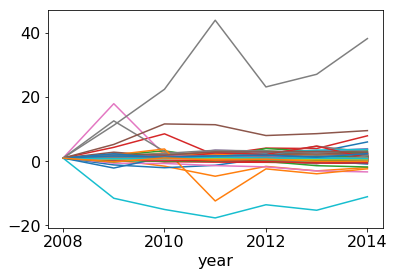

In [244]:
ddd = (dd / (dd.iloc[0] + 1)).fillna(0)
ddd.plot(legend=False)

In [246]:
ddd.iloc[-1].sort_values().head(n=20)

        dest_eu  origin
net     eu       isl      -11.053085
                 svn       -3.311347
        ex-eu    and       -2.356573
        eu       fin       -1.958507
        ex-eu    ita       -1.780676
                 nor       -0.861995
                 bgr       -0.654031
                 rou       -0.489744
        eu       pol       -0.480228
        ex-eu    lva       -0.270633
                 hun       -0.090451
        eu       esp       -0.054750
export  eu       vat        0.000000
        ex-eu    vat        0.000000
net     eu       vat        0.000000
import  ex-eu    vat        0.000000
        eu       vat        0.000000
net     ex-eu    vat        0.000000
                 prt        0.034661
        eu       rou        0.268354
Name: 2014, dtype: float64

In [245]:
ddd.iloc[-1].sort_values().tail(n=20)

        dest_eu  origin
import  eu       gib        1.982739
export  ex-eu    bih        2.101261
net     eu       che        2.275892
                 svk        2.362398
export  ex-eu    mda        2.364459
net     ex-eu    ukr        2.380357
                 blr        2.408086
export  ex-eu    srb        2.593357
import  ex-eu    mda        2.638889
net     ex-eu    mda        2.844132
                 che        2.877684
export  ex-eu    alb        3.044622
                 mkd        3.228618
net     eu       swe        3.643801
        ex-eu    deu        3.702424
export  ex-eu    mne        3.914304
        eu       gib        6.026311
import  ex-eu    and        7.944745
net     ex-eu    smr        9.561269
export  ex-eu    and       38.272808
Name: 2014, dtype: float64